### Euler methods

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
try:
  import torch
except ModuleNotFoundError:
  !pip3 install --quiet torch torchvision torchaudio

try:
  import numba
except ModuleNotFoundError:
  !pip install --quiet numba

In [3]:
import numba
from numba import jit, prange

import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [4]:
def ode_solve(z0, t0, t1, func):
    h_max = 0.05
    n_steps = np.ceil((abs(t1 - t0)/h_max).max().item())
    n_steps = n_steps.astype(np.uint)
    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * func(z, t)
        t = t + h
    return z

In [5]:
def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [6]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [7]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [8]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [9]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = nn.Conv2d(dim+ 1, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(dim)
        self.conv2 = nn.Conv2d(dim + 1, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [10]:
from torchvision.models import vgg11_bn
# simple_model = vgg11_bn(weights=None)
# simple_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)

In [11]:
class NewModel(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = vgg11_bn(weights=None)
        # self.pretrained.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])

        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

In [12]:
# simple_model._modules.keys()

In [13]:
intermediateModel = NewModel(output_layer='features')

newModel = nn.Sequential(
    intermediateModel,
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 64, 3, 1),
)

In [14]:
image = torch.rand((1, 3, 224, 224))
# simple_model(image).size()

In [15]:
class VggBaseClassifier(nn.Module):
    def __init__(self, model, ode):
        super(VggBaseClassifier, self).__init__()
        self.base_model = model
        self.feature = ode
        self.norm = nn.BatchNorm2d(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.base_model(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [16]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = VggBaseClassifier(newModel, ode)
if use_cuda:
    model = model.cuda()

In [17]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 89187992.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [20]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [23]:
import time
# time taken
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    startTime=time.time()
    train_losses += train(epoch)
    endTime=time.time()
    elapsedTime=endTime-startTime
    if torch.cuda.is_available():
      # Write it to a GPU file
      with open('GpuTiming.txt','a') as file:
        file.write(f"EPOCH={epoch} ElapsedTime=,{elapsedTime} Train Loss= {train_losses}\n")
    else:
      # Write it to a GPU file
      with open('CpuTiming.txt','a') as file:
        file.write(f"EPOCH={epoch} ElapsedTime=,{elapsedTime} Train Loss= {train_losses}\n")
    test()

Testing...


<ipython-input-20-21ca1da03176>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/313 [00:00<?, ?it/s]

Test Accuracy: 10.000%
Training Epoch 1...


<ipython-input-19-7bd42b6f5b96>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss: 1.16456
Testing...


  0%|          | 0/313 [00:00<?, ?it/s]

Test Accuracy: 71.180%
Training Epoch 2...


  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from torchsummary import summary
summary(newModel, (3, 100, 100))
# tempModel = ContinuousNeuralMNISTClassifier(ode)
# summary(tempModel, (1, 224, 224))

In [ ]:
test()

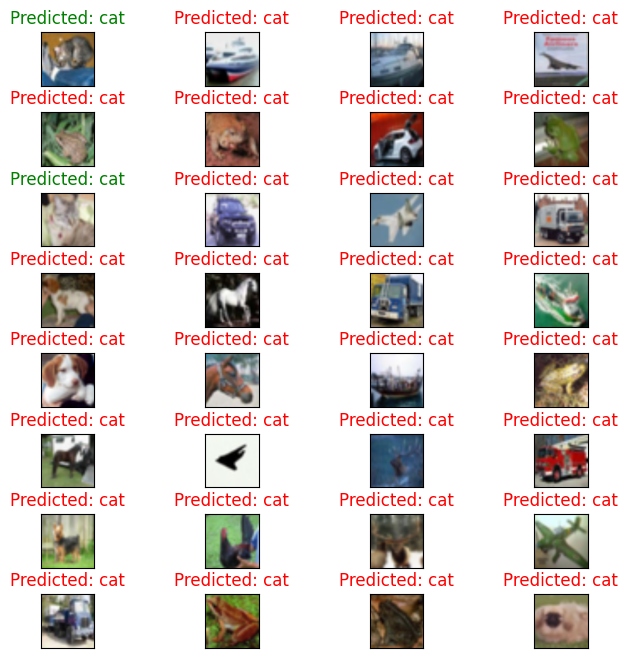

In [28]:

images, labels = next(iter(test_loader))
import matplotlib.pyplot as plt
images.size()

inv_normalize = transforms.Normalize(
    (-1, -1, -1),
    (1/0.5, 1/0.5, 1/0.5)
)

visualized_correct = 0
visualized_num = 0
with torch.no_grad():
    fig, axes = plt.subplots(8, 4, figsize=(8,8))
    for i in range(8):
        for j in range(4):
            visualized_num += 1
            value = i * 4 + j
            predicted = model(images[value].unsqueeze(0).cuda()).cpu().argmax()
            predicted = np.round(predicted).numpy().astype(int).item()
            correct = labels[value].numpy().astype(int).item()

            if predicted == labels[value]:
                visualized_correct += 1
                color = "green"
            else:
                color = "red"
            axes[i, j].set_title(f"Predicted: {classes[predicted]}", color=color)
            axes[i, j].set_xlabel(f"Correct: {classes[correct]}", color=color)
            temp_img = inv_normalize(images[value])
            axes[i, j].imshow(temp_img.permute(1, 2, 0))
            plt.subplots_adjust(hspace=0.5, wspace=0.3)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

In [25]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4400.34
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i